In [1]:
import jax.numpy as jnp
from jax import vmap, jit
from spice.models.mesh_transform import transform
from transformer_payne import Blackbody
from spice.models import IcosphereModel
bb = Blackbody()
m = transform(IcosphereModel.construct(1000, 1., 1., bb.to_parameters(), bb.parameter_names), jnp.array([0.0, 0.0, -10.0]))


/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


In [2]:
import astropy.constants as const
def einstein_radius(lens_mass, distance_lens, distance_source):
    d_lens_source = distance_source - distance_lens
    return jnp.sqrt(4*const.G/(const.c**2)*lens_mass*d_lens_source/distance_lens/distance_source)*2.06*1e5

# sample_ang_rad = 0.00936

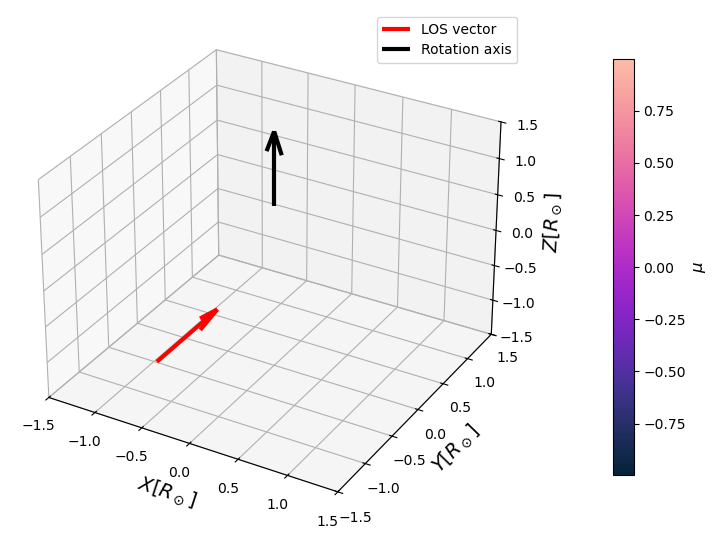

In [5]:
from spice.plots.plot_mesh import plot_3D
import matplotlib
%matplotlib inline

plot_3D(m);

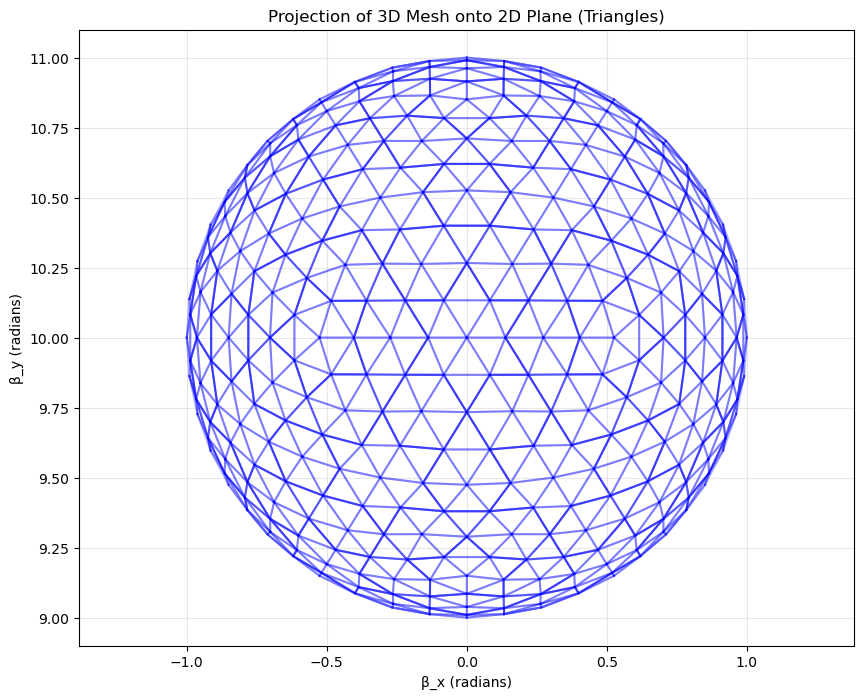

In [6]:
# Plot the angles (projection of 3D mesh onto 2D)
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

plt.figure(figsize=(10, 8))
# Plot triangles instead of just vertices
for i in range(len(m.faces)):
    # Get the vertices for each face
    face = m.faces[i].astype(int)
    # Get the 2D coordinates of each vertex in the face
    coords = m.cast_vertices[face]#*sample_ang_rad   
    # Plot the triangle
    plt.plot(coords[:, 0], coords[:, 1], 'b-', alpha=0.3)

plt.title('Projection of 3D Mesh onto 2D Plane (Triangles)')
plt.xlabel('β_x (radians)')
plt.ylabel('β_y (radians)')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show();


In [20]:
@jit
def point_lens_images(beta, θ_E=1.0):
    """
    beta - arcsec / einstein radius
    theta_E - einstein radius [arcsec]
    """
    w = beta[0] + 1j * beta[1]
    w /= θ_E
    w_abs_sq = w.real**2 + w.imag**2
    #  Compute the image locations using the quadratic formula
    z1 = 0.5 * w * (1.0 + jnp.sqrt(1 + 4 / w_abs_sq))
    z2 = 0.5 * w * (1.0 - jnp.sqrt(1 + 4 / w_abs_sq))
    return jnp.array([z1.real, z1.imag]), jnp.array([z2.real, z2.imag])

In [21]:
m.cast_vertices[m.faces.astype(int)].shape

(1280, 3, 2)

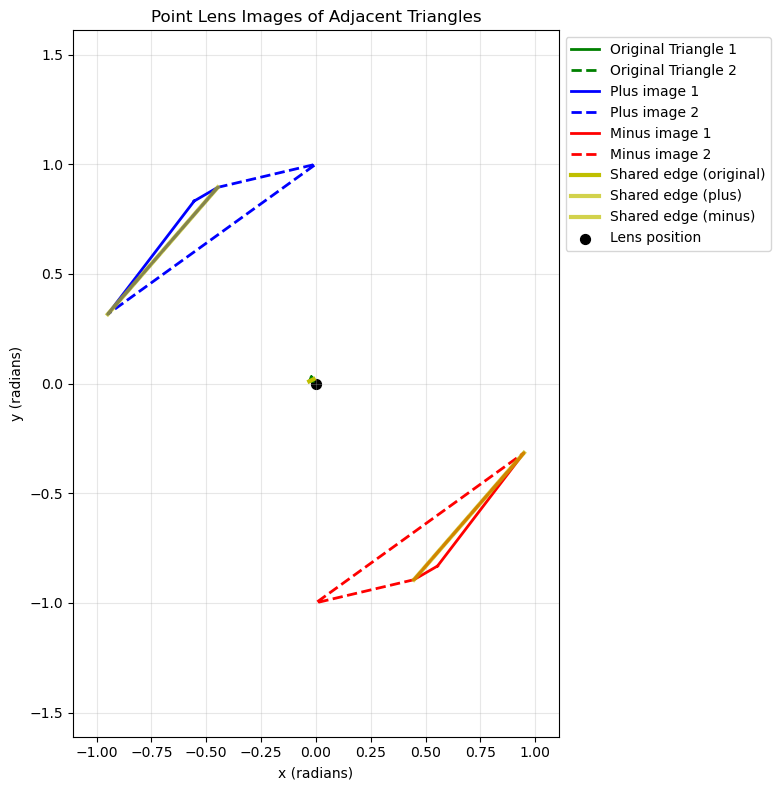

Checking if adjacency is preserved in the images:
Original triangles share vertices at positions 1-2 of triangle1 and 0-1 of triangle2
Plus images: Vertices at these positions are identical: True
Minus images: Vertices at these positions are identical: True

Conclusion: Adjacent triangles in the source plane map to adjacent triangles in the image plane.


In [22]:
# Test point_lens_images on adjacent triangles
import numpy as np
from jax import numpy as jnp

# Define Einstein radius for testing
def einstein_radius(M, D_L, D_S):
    """
    Calculate the Einstein radius.
    
    Parameters:
    M: Mass of the lens (kg)
    D_L: Distance to the lens (m)
    D_S: Distance to the source (m)
    
    Returns:
    Einstein radius in radians
    """
    G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
    c = 299792458.0  # Speed of light in m/s
    
    # Calculate the Einstein radius
    θ_E = np.sqrt((4 * G * M) / (c**2) * (D_S - D_L) / (D_L * D_S))
    return θ_E

# Define a sample angular radius for the star
sample_ang_rad = 1e-8  # in radians

# Create two adjacent triangles that share an edge
triangle1 = jnp.array([
    [-0.02, 0.03],
    [-0.01, 0.02],
    [-0.03, 0.01]
])

triangle2 = jnp.array([
    [-0.01, 0.02],  # shared vertex with triangle1
    [-0.03, 0.01],  # shared vertex with triangle1
    [0.00, 0.01]    # new vertex
])

# Apply point_lens_images to each vertex of both triangles
def get_images(triangle, θ_E=1.0):
    θ_plus_list = []
    θ_minus_list = []
    
    for vertex in triangle:
        θ_plus, θ_minus = point_lens_images(vertex * sample_ang_rad, θ_E=θ_E)
        θ_plus_list.append(θ_plus)
        θ_minus_list.append(θ_minus)
    
    return jnp.array(θ_plus_list), jnp.array(θ_minus_list)

θ_plus1, θ_minus1 = get_images(triangle1)
θ_plus2, θ_minus2 = get_images(triangle2)

# Plot the original triangles and their images
plt.figure(figsize=(8, 8))

# Plot original triangles
plt.plot(np.append(triangle1[:, 0], triangle1[0, 0]), 
         np.append(triangle1[:, 1], triangle1[0, 1]), 'g-', linewidth=2, label='Original Triangle 1')
plt.plot(np.append(triangle2[:, 0], triangle2[0, 0]), 
         np.append(triangle2[:, 1], triangle2[0, 1]), 'g--', linewidth=2, label='Original Triangle 2')

# Plot plus images
plt.plot(np.append(θ_plus1[:, 0], θ_plus1[0, 0]), 
         np.append(θ_plus1[:, 1], θ_plus1[0, 1]), 'b-', linewidth=2, label='Plus image 1')
plt.plot(np.append(θ_plus2[:, 0], θ_plus2[0, 0]), 
         np.append(θ_plus2[:, 1], θ_plus2[0, 1]), 'b--', linewidth=2, label='Plus image 2')

# Plot minus images
plt.plot(np.append(θ_minus1[:, 0], θ_minus1[0, 0]), 
         np.append(θ_minus1[:, 1], θ_minus1[0, 1]), 'r-', linewidth=2, label='Minus image 1')
plt.plot(np.append(θ_minus2[:, 0], θ_minus2[0, 0]), 
         np.append(θ_minus2[:, 1], θ_minus2[0, 1]), 'r--', linewidth=2, label='Minus image 2')

# Highlight the shared edge in the original triangles
shared_edge = jnp.array([triangle1[1], triangle1[2]])
plt.plot(shared_edge[:, 0], shared_edge[:, 1], 'y-', linewidth=3, label='Shared edge (original)')

# Highlight the shared edge in the plus images
shared_edge_plus = jnp.array([θ_plus1[1], θ_plus1[2]])
plt.plot(shared_edge_plus[:, 0], shared_edge_plus[:, 1], 'y-', linewidth=3, alpha=0.7, label='Shared edge (plus)')

# Highlight the shared edge in the minus images
shared_edge_minus = jnp.array([θ_minus1[1], θ_minus1[2]])
plt.plot(shared_edge_minus[:, 0], shared_edge_minus[:, 1], 'y-', linewidth=3, alpha=0.7, label='Shared edge (minus)')

plt.scatter(0, 0, color='black', s=50, label='Lens position')
plt.title('Point Lens Images of Adjacent Triangles')
plt.xlabel('x (radians)')
plt.ylabel('y (radians)')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Print confirmation of adjacency preservation
print("Checking if adjacency is preserved in the images:")
print(f"Original triangles share vertices at positions 1-2 of triangle1 and 0-1 of triangle2")
print(f"Plus images: Vertices at these positions are identical: {np.allclose(θ_plus1[1:], θ_plus2[:2])}")
print(f"Minus images: Vertices at these positions are identical: {np.allclose(θ_minus1[1:], θ_minus2[:2])}")
print("\nConclusion: Adjacent triangles in the source plane map to adjacent triangles in the image plane.")


In [23]:
from jax import vmap
import astropy.units as u
sample_einstein_radius = einstein_radius(u.M_sun.to(u.kg), 1.0*u.pc.to(u.m), 2.0*u.pc.to(u.m))
sample_einstein_radius
pvmamp = vmap(point_lens_images, in_axes=(0, None))(m.cast_vertices[m.faces.astype(int)].reshape(-1, 2)*sample_ang_rad/sample_einstein_radius, 1.0)

In [24]:
m.cast_vertices[m.faces.astype(int)].shape

(1280, 3, 2)

In [25]:
pvmamp[0].shape


(3840, 2)

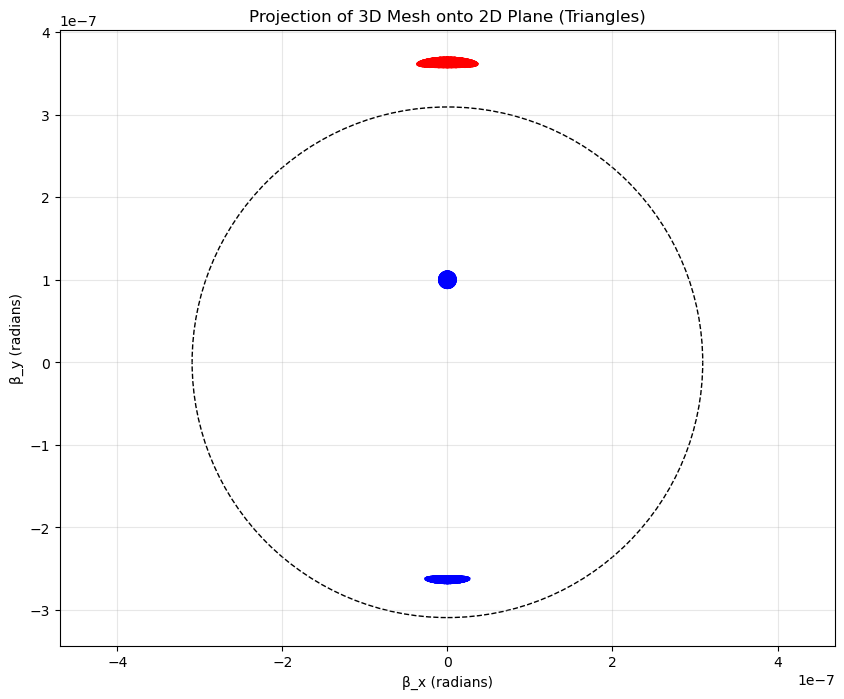

In [29]:
plt.figure(figsize=(10, 8))
imgs1 = pvmamp[0].reshape((-1, 3, 2))
imgs2 = pvmamp[1].reshape((-1, 3, 2))
# Plot triangles instead of just vertices
for i in range(imgs2.shape[0]):
    # # Plot each triangle and close it by connecting the last point to the first
    plt.plot(np.append(imgs2[i, :, 0], imgs2[i, 0, 0])*sample_einstein_radius, 
             np.append(imgs2[i, :, 1], imgs2[i, 0, 1])*sample_einstein_radius, 'b-', alpha=0.3)
    plt.plot(np.append(imgs1[i, :, 0], imgs1[i, 0, 0])*sample_einstein_radius, 
             np.append(imgs1[i, :, 1], imgs1[i, 0, 1])*sample_einstein_radius, 'r-', alpha=0.3)
    
# Plot Einstein radius circle
circle = plt.Circle((0, 0), sample_einstein_radius, fill=False, color='k', linestyle='--', label='Einstein Radius')
plt.gca().add_patch(circle)

    
for i in range(len(m.faces)):
    # Get the vertices for each face
    face = m.faces[i].astype(int)
    # Get the 2D coordinates of each vertex in the face
    coords = m.cast_vertices[face]*sample_ang_rad   
    # Plot the triangle
    plt.plot(coords[:, 0], coords[:, 1], 'b-', alpha=0.3)

plt.title('Projection of 3D Mesh onto 2D Plane (Triangles)')
plt.xlabel('β_x (radians)')
plt.ylabel('β_y (radians)')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show();

In [ ]:
def lensed_mesh(new_vertices):
    # all parameters will remain the same except for the vertices?
    